<a href="https://colab.research.google.com/github/lehanvats/AI-based-Lung-Disease-Classification/blob/main/Pneumonia_TB_classification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Install required packages if needed
# !pip install kaggle torch torchvision scikit-learn matplotlib seaborn tqdm pillow opencv-python

import os
import zipfile
import random
import json
from pathlib import Path
from shutil import copy2
from collections import Counter
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                           classification_report, confusion_matrix, roc_auc_score)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

print("All dependencies imported successfully!")

All dependencies imported successfully!


### Initialize Kaggle

In [14]:
import os
# Install python-dotenv if not already installed
try:
    import dotenv
except ImportError:
    print("python-dotenv not found. Installing...")
    !pip install python-dotenv
    import dotenv

# Load environment variables from .env file
dotenv_file = dotenv.find_dotenv()
if dotenv_file:
    dotenv.load_dotenv(dotenv_file)
    print("✅ .env file loaded successfully!")
    # --- Diagnostic Print ---
    print(f"Diagnostic check - KAGGLE_USERNAME after loading .env: {os.getenv('KAGGLE_USERNAME')}")
    # --- End Diagnostic Print ---
else:
    print("⚠️ .env file not found. Please ensure it exists in the notebook directory.")


# ============================================
# ENTER YOUR KAGGLE CREDENTIALS HERE
# ============================================

# Set up Kaggle API credentials - now read from loaded .env
KAGGLE_USERNAME = os.getenv('KAGGLE_USERNAME')
KAGGLE_KEY = os.getenv('KAGGLE_KEY')

# Optional: Set environment variables explicitly if loading didn't work as expected
# os.environ['KAGGLE_USERNAME'] = str(KAGGLE_USERNAME) if KAGGLE_USERNAME else ''
# os.environ['KAGGLE_KEY'] = str(KAGGLE_KEY) if KAGGLE_KEY else ''


# Test Kaggle API connection
try:
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    # Authenticate using environment variables
    # Kaggle API automatically picks up KAGGLE_USERNAME and KAGGLE_KEY from os.environ
    api.authenticate()
    print("✅ Kaggle API authenticated successfully!")
    # Display the username that was successfully authenticated
    print(f"Connected as: {os.getenv('KAGGLE_USERNAME')}")
except Exception as e:
    print(f"❌ Kaggle API authentication failed: {e}")
    print("Please check your username and API key in the .env file.")
    print("Make sure you have added your credentials to the .env file and loaded them.")

✅ .env file loaded successfully!
Diagnostic check - KAGGLE_USERNAME after loading .env: lehanvats
✅ Kaggle API authenticated successfully!
Connected as: lehanvats


### Retrieving Dataset

In [15]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

# Kaggle datasets
KAGGLE_DATASETS = {
    'pneumonia_normal': 'paultimothymooney/chest-xray-pneumonia',
    'tuberculosis': 'yasserhessein/tuberculosis-chest-x-rays-images'
}

DOWNLOAD_DIR = Path('kaggle_downloads')
EXTRACT_DIR = Path('kaggle_extracted')
SAMPLED_DIR = Path('data_for_training')

# Create directories
for dir_path in [DOWNLOAD_DIR, EXTRACT_DIR, SAMPLED_DIR]:
    dir_path.mkdir(exist_ok=True)

print('📦 Starting dataset downloads...')
print('Datasets to download:')
for k, v in KAGGLE_DATASETS.items():
    print(f'  - {k}: {v}')

# Init Kaggle API
api = KaggleApi()
api.authenticate()

# Download datasets
for key, slug in KAGGLE_DATASETS.items():
    print(f'\n🚚 Processing {key}...')

    dataset_name = slug.split('/')[-1]
    dataset_files = list(DOWNLOAD_DIR.glob(f"*{dataset_name}*"))
    if dataset_files:
        print(f'   Already downloaded: {dataset_files[0].name}')
        continue

    try:
        print(f'   Downloading {slug}...')
        api.dataset_download_files(slug, path=str(DOWNLOAD_DIR), unzip=False, quiet=False)
        print(f'   ✅ Downloaded successfully')
    except Exception as e:
        print(f'   ❌ Download error: {e}')

print('\n📂 Extracting datasets...')
# Extract all zip files
for zip_file in DOWNLOAD_DIR.glob('*.zip'):
    extract_path = EXTRACT_DIR / zip_file.stem

    if extract_path.exists() and any(extract_path.iterdir()):
        print(f'   Already extracted: {zip_file.name}')
        continue

    try:
        extract_path.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(path=extract_path)
        print(f'   ✅ Extracted: {zip_file.name}')
    except Exception as e:
        print(f'   ❌ Extraction error for {zip_file.name}: {e}')

print('\n✅ Download and extraction complete!')

# -----------------------------
# Dataset composition summary
# -----------------------------

CLASS_DIRS = {
    "Normal": [
        # Pneumonia dataset normals
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/train/NORMAL",
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/val/NORMAL",
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/test/NORMAL",
        # TB dataset normals
        EXTRACT_DIR / "tuberculosis-chest-x-rays-images/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays"
    ],
    "Pneumonia": [
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/train/PNEUMONIA",
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/val/PNEUMONIA",
        EXTRACT_DIR / "chest-xray-pneumonia/chest_xray/test/PNEUMONIA",
    ],
    "Tuberculosis": [
        EXTRACT_DIR / "tuberculosis-chest-x-rays-images/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays"
    ]
}


counts = {}
for cls, paths in CLASS_DIRS.items():
    total = 0
    for p in paths:
        if p.exists():
            # ✅ recursive scan to catch nested folders
            total += len(list(p.rglob("*.*")))
    counts[cls] = total

print("\n📊 Final dataset composition:")
for cls, n in counts.items():
    print(f"   {cls}: {n} images")
print(f"   Total: {sum(counts.values())} images")

📦 Starting dataset downloads...
Datasets to download:
  - pneumonia_normal: paultimothymooney/chest-xray-pneumonia
  - tuberculosis: yasserhessein/tuberculosis-chest-x-rays-images

🚚 Processing pneumonia_normal...
   Already downloaded: chest-xray-pneumonia.zip

🚚 Processing tuberculosis...
   Already downloaded: tuberculosis-chest-x-rays-images.zip

📂 Extracting datasets...
   Already extracted: tuberculosis-chest-x-rays-images.zip
   Already extracted: chest-xray-pneumonia.zip

✅ Download and extraction complete!

📊 Final dataset composition:
   Normal: 2097 images
   Pneumonia: 4273 images
   Tuberculosis: 2494 images
   Total: 8864 images


### Data Sampling

In [16]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Sampling configuration
SAMPLE_COUNTS = {
    'Normal': 2000,
    'Pneumonia': 1400,
    'Tuberculosis': 1400
}

# Class folder name mappings (expanded for TB dataset structure)
class_folder_names = {
    'Normal': ['NORMAL', 'Normal', 'normal', 'Normal Chest X-rays'],
    'Pneumonia': ['PNEUMONIA', 'Pneumonia', 'pneumonia', 'virus', 'bacteria'],
    'Tuberculosis': ['Tuberculosis', 'TUBERCULOSIS', 'tb', 'TB', 'Tuberculosis-RGB', 'TB Chest X-rays']
}

print('🔎 Searching for class folders...')
found_images = {cls: [] for cls in class_folder_names.keys()}

# Search for images in extracted folders
for root_dir in EXTRACT_DIR.iterdir():
    if not root_dir.is_dir():
        continue

    print(f'   Scanning: {root_dir.name}')

    for class_name, folder_names in class_folder_names.items():
        for path in root_dir.glob('**/*'):
            if path.is_dir() and path.name in folder_names:
                # Find image files
                image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp']
                images = [
                    f for f in path.glob('*.*')
                    if f.suffix.lower() in image_extensions
                ]

                if images:
                    found_images[class_name].extend(images)
                    print(f'     Found {len(images)} {class_name} images in {path.name}/')

# Display findings
print('\n📊 Image search results:')
for class_name, images in found_images.items():
    print(f'   {class_name}: {len(images)} images found')

# Check for missing classes
missing_classes = [cls for cls, imgs in found_images.items() if len(imgs) == 0]
if missing_classes:
    print(f'\n⚠️  Warning: Missing classes: {missing_classes}')
    print('   Check the kaggle_extracted folder and adjust class_folder_names if needed')
else:
    print('\n✅ All classes found!')

# Sample and organize images
print('\n📊 Sampling and organizing images...')
for class_name, desired_count in SAMPLE_COUNTS.items():
    images = found_images[class_name]

    if len(images) == 0:
        print(f'   ❌ No images found for {class_name}')
        continue

    if len(images) < desired_count:
        print(f'   ⚠️  {class_name}: Found {len(images)}, needed {desired_count}. Using all available.')
        sampled_images = images
    else:
        sampled_images = random.sample(images, desired_count)

    # Create / clean class directory
    class_dir = SAMPLED_DIR / class_name
    if class_dir.exists():
        for old_file in class_dir.glob('*.*'):
            old_file.unlink()  # delete old files
    else:
        class_dir.mkdir(parents=True, exist_ok=True)

    # Copy sampled images
    copied_count = 0
    for src_path in sampled_images:
        dst_path = class_dir / src_path.name

        # Handle duplicate names
        if dst_path.exists():
            dst_path = class_dir / f"{dst_path.stem}_{random.randint(0,99999)}{dst_path.suffix}"

        try:
            copy2(src_path, dst_path)
            copied_count += 1
        except Exception as e:
            print(f'     Error copying {src_path.name}: {e}')

    print(f'   ✅ {class_name}: Copied {copied_count} images')

print('\n🎉 Data sampling complete! Check the data_for_training/ folder.')

# Verify final counts
print('\n📊 Final dataset composition:')
total_images = 0
for class_name in SAMPLE_COUNTS.keys():
    class_path = SAMPLED_DIR / class_name
    if class_path.exists():
        count = len(list(class_path.glob('*.*')))
        print(f'   {class_name}: {count} images')
        total_images += count
    else:
        print(f'   {class_name}: 0 images (folder not found)')

print(f'   Total: {total_images} images')

🔎 Searching for class folders...
   Scanning: chest-xray-pneumonia
     Found 8 Normal images in NORMAL/
     Found 1341 Normal images in NORMAL/
     Found 234 Normal images in NORMAL/
     Found 8 Normal images in NORMAL/
     Found 1341 Normal images in NORMAL/
     Found 234 Normal images in NORMAL/
     Found 8 Normal images in NORMAL/
     Found 1341 Normal images in NORMAL/
     Found 234 Normal images in NORMAL/
     Found 8 Pneumonia images in PNEUMONIA/
     Found 3875 Pneumonia images in PNEUMONIA/
     Found 390 Pneumonia images in PNEUMONIA/
     Found 8 Pneumonia images in PNEUMONIA/
     Found 3875 Pneumonia images in PNEUMONIA/
     Found 390 Pneumonia images in PNEUMONIA/
     Found 8 Pneumonia images in PNEUMONIA/
     Found 3875 Pneumonia images in PNEUMONIA/
     Found 390 Pneumonia images in PNEUMONIA/
   Scanning: tuberculosis-chest-x-rays-images
     Found 514 Normal images in Normal Chest X-rays/
     Found 2494 Tuberculosis images in TB Chest X-rays/

📊 Image s

### Data Processing

In [23]:
# Configuration
DATA_DIR = 'data_for_training'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0

# Import shutil
import shutil

print('⚙️ Setting up data preprocessing...')

# Check if data directory exists
if not Path(DATA_DIR).exists():
    print(f"❌ Data directory '{DATA_DIR}' not found!")
    print("Please run the previous cells to download and organize the data first.")
else:
    print(f"✅ Data directory found: {DATA_DIR}")

# Verify class folders
print('\n📊 Verifying class folders:')
# Identify actual class directories within DATA_DIR, excluding potential split directories
actual_class_dirs = [d for d in Path(DATA_DIR).iterdir() if d.is_dir() and d.name not in ['train', 'val', 'test', 'val_duplicates_removed']]
actual_class_names = sorted([d.name for d in actual_class_dirs]) # Ensure consistent class order

if not actual_class_dirs:
    print(f"❌ No actual class folders found directly in '{DATA_DIR}'. Expected folders like 'Normal', 'Pneumonia', 'Tuberculosis'.")
else:
    print(f"✅ Found actual class folders: {actual_class_names}")
    for class_name in actual_class_names:
        class_path = Path(DATA_DIR) / class_name
        count = len(list(class_path.rglob('*.*'))) # Use rglob for nested images
        print(f'   {class_name}: {count} images')


# Remove hidden files (like .DS_Store or ._*) that can cause errors from actual class folders
print('\n🧹 Cleaning up hidden files from actual class folders...')
removed_count = 0
for class_dir in actual_class_dirs:
    for file_path in class_dir.rglob('.*'): # Use rglob for nested hidden files
        if file_path.is_file():
            try:
                file_path.unlink()
                removed_count += 1
            except Exception as e:
                print(f'     Error removing {file_path}: {e}')
if removed_count > 0:
    print(f'   ✅ Removed {removed_count} hidden files.')
else:
    print('   ✅ No hidden files found in actual class folders.')


# Manually collect samples (filepaths and labels) from actual class folders
print('\n📚 Collecting image samples from actual class folders...')
all_samples = []
class_to_idx = {cls_name: i for i, cls_name in enumerate(actual_class_names)}

image_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

for class_dir in actual_class_dirs:
    class_name = class_dir.name
    class_idx = class_to_idx[class_name]
    for img_path in class_dir.rglob('*'): # Use rglob to find images in nested folders
         if img_path.is_file() and img_path.suffix.lower() in image_extensions:
             all_samples.append((str(img_path), class_idx))

if not all_samples:
    print("❌ No image files found in the actual class folders!")
    print("Please ensure the actual class folders (e.g., Normal, Pneumonia, Tuberculosis) within 'data_for_training' contain image files with supported extensions.")
    full_dataset = None # Indicate failure
    class_names = []
else:
    print(f'   ✅ Collected {len(all_samples)} image samples.')
    # Use the collected class names
    class_names = actual_class_names


    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Create stratified split (70% train, 15% val, 15% test) based on collected samples
    print('\n✂️  Creating stratified train/validation/test splits...')
    # We need targets for splitting, which are the class indices from all_samples
    all_targets = np.array([s[1] for s in all_samples])
    all_indices = np.arange(len(all_samples))

    # First split: 70% train, 30% temp (for val + test)
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        all_indices, all_targets, test_size=0.30, random_state=42, stratify=all_targets
    )

    # Second split: 15% val, 15% test from the 30% temp
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f'   Train: {len(train_idx)} samples ({len(train_idx)/len(all_samples)*100:.1f}%)')
    print(f'   Validation: {len(val_idx)} samples ({len(val_idx)/len(all_samples)*100:.1f}%)')
    print(f'   Test: {len(test_idx)} samples ({len(test_idx)/len(all_samples)*100:.1f}%)')


    # Create dataset splits using Subset
    # Note: Transforms are applied directly to the ImageFolder dataset and will be used by subsets.
    # However, for train_dataset, we need train_transforms, and for val/test, we need val_transforms.
    # PyTorch Subsets inherit the transform of the original dataset.
    # A common way to handle different transforms for subsets is to reassign the transform after creating subsets.
    # Or, create ImageFolder instances per split directory (which is what we had before).
    # Let's go back to creating ImageFolder instances per split directory to align with the rest of the notebook structure
    # and avoid the custom DatasetWithTransform wrapper.

    # We need to recreate the split directories if they don't exist or contain old data
    TRAIN_DIR = Path(DATA_DIR) / 'train'
    VAL_DIR = Path(DATA_DIR) / 'val'
    TEST_DIR = Path(DATA_DIR) / 'test'

    for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        if dir_path.exists():
            # Clean up old data only if we are going to repopulate them
             print(f'   🧹 Cleaning up old data in {dir_path}...')
             try:
                 for item in dir_path.iterdir():
                     if item.is_dir(): shutil.rmtree(item)
                     else: item.unlink()
             except Exception as e:
                 print(f'   ⚠️  Error cleaning {dir_path}: {e}')

        dir_path.mkdir(parents=True, exist_ok=True)

    # Copy sampled images into the new split directories
    print('\n📂 Copying images to split directories...')

    split_mappings = {
        TRAIN_DIR: train_idx,
        VAL_DIR: val_idx,
        TEST_DIR: test_idx
    }

    # Dictionary mapping original file paths to their class names for copying
    original_filepath_to_class_name = {filepath: actual_class_names[class_idx] for filepath, class_idx in all_samples}


    for split_dir, indices in split_mappings.items():
        print(f'   Processing {split_dir.name}...')
        copied_count = 0
        for idx in indices:
            # Get the original filepath from the collected samples using the index
            filepath, class_idx = all_samples[idx]
            class_name = actual_class_names[class_idx] # Get class name from actual_class_names

            target_dir = split_dir / class_name
            target_dir.mkdir(parents=True, exist_ok=True)
            target_path = target_dir / Path(filepath).name

            # Handle potential duplicate filenames within the split
            if target_path.exists():
                 target_path = target_dir / f"{target_path.stem}_{random.randint(0,99999)}{target_path.suffix}"

            try:
                shutil.copy2(filepath, target_path)
                copied_count += 1
            except Exception as e:
                print(f'     Error copying {filepath}: {e}')
        print(f'   ✅ Copied {copied_count} images to {split_dir.name}')


    # Now load datasets directly from split directories with appropriate transforms
    print('\n📊 Loading datasets from split directories with transforms...')
    try:
        train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
        val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)
        test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms) # Use val_transforms for test

        print(f'   Train images: {len(train_dataset)}')
        print(f'   Validation images: {len(val_dataset)}')
        print(f'   Test images: {len(test_dataset)}')


    except FileNotFoundError as e:
        print(f"❌ Error loading datasets from splits: {e}")
        print("Please ensure the train, val, and test subfolders were created correctly within data_for_training and contain the class subfolders.")
        train_dataset = None
        val_dataset = None
        test_dataset = None


    # Proceed with dataloaders only if datasets loaded successfully
    if train_dataset and val_dataset and test_dataset: # Ensure all three are loaded
        # Display class distribution from the loaded datasets
        print('\n📈 Class distribution:')
        train_counts = Counter(train_dataset.targets)
        val_counts = Counter(val_dataset.targets)
        test_counts = Counter(test_dataset.targets)

        # Use the class names from the loaded datasets, which should match actual_class_names
        dataset_class_names = train_dataset.classes # Assuming class order is consistent
        if dataset_class_names:
            for i, class_name in enumerate(dataset_class_names):
                print(f'   {class_name}:')
                print(f'     Train: {train_counts.get(i, 0):3d} | Val: {val_counts.get(i, 0):3d} | Test: {test_counts.get(i, 0):3d}')
        else:
             print("   ❌ Class names not defined after loading split datasets.")


        # Create data loaders
        print('\n⚙️  Creating data loaders...')
        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=NUM_WORKERS, pin_memory=True # Use pin_memory=True if GPU is available
        )
        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=NUM_WORKERS, pin_memory=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=NUM_WORKERS, pin_memory=True
        )

        # Test data loader
        print('\n🧪 Testing data loader...')
        try:
            sample_batch = next(iter(train_loader))
            images, labels = sample_batch
            print(f'   ✅ Batch shape: {images.shape} (images), {labels.shape} (labels)')
            print('   Data loaders ready!')
        except Exception as e:
            print(f'   ❌ Error testing data loader: {e}')

    else:
        print("\n🛑 Data loading failed. Data loaders were not created.")

# Define class_names at the top level scope if dataset loading was successful
if 'actual_class_names' in locals() and actual_class_names:
    class_names = actual_class_names
elif 'train_dataset' in locals() and train_dataset:
     class_names = train_dataset.classes
else:
     class_names = [] # Ensure class_names is defined even on failure

⚙️ Setting up data preprocessing...
✅ Data directory found: data_for_training

📊 Verifying class folders:
✅ Found actual class folders: ['Normal', 'Pneumonia', 'Tuberculosis']
   Normal: 1414 images
   Pneumonia: 912 images
   Tuberculosis: 1400 images

🧹 Cleaning up hidden files from actual class folders...
   ✅ No hidden files found in actual class folders.

📚 Collecting image samples from actual class folders...
   ✅ Collected 3726 image samples.

✂️  Creating stratified train/validation/test splits...
   Train: 2608 samples (70.0%)
   Validation: 559 samples (15.0%)
   Test: 559 samples (15.0%)
   🧹 Cleaning up old data in data_for_training/train...
   🧹 Cleaning up old data in data_for_training/val...
   🧹 Cleaning up old data in data_for_training/test...

📂 Copying images to split directories...
   Processing train...
   ✅ Copied 2608 images to train
   Processing val...
   ✅ Copied 559 images to val
   Processing test...
   ✅ Copied 559 images to test

📊 Loading datasets from sp

### Removing Duplicates (a bit of accuracy increase)

In [18]:
import os
from pathlib import Path

# Paths
DATA_DIR = Path("data_for_training")
VAL_DIR = DATA_DIR / "val"

# Full list of duplicates (validation side)
duplicates_val_side = [
    "Pneumonia/person518_bacteria_2199.jpeg",
    "Normal/NORMAL2-IM-0368-0001.jpeg",
    "Tuberculosis/TB.752.jpg",
    "Normal/IM-0521-0001.jpeg",
    "Normal/NORMAL2-IM-1153-0001.jpeg",
    "Normal/IM-0364-0001_60981.jpeg",
    "Normal/NORMAL2-IM-1218-0001.jpeg",
    "Normal/IM-0630-0001.jpeg",
    "Normal/NORMAL2-IM-1311-0001.jpeg",
    "Normal/NORMAL2-IM-0718-0001_49131.jpeg"
]

# Create a folder to move removed val duplicates
REMOVED_DIR = DATA_DIR / "val_duplicates_removed"
REMOVED_DIR.mkdir(parents=True, exist_ok=True)

removed_count = 0
for rel_path in duplicates_val_side:
    val_file = VAL_DIR / rel_path
    if val_file.exists():
        target_path = REMOVED_DIR / val_file.name
        os.rename(val_file, target_path)  # move instead of delete
        print(f"➡️ Moved duplicate: {val_file} -> {target_path}")
        removed_count += 1
    else:
        print(f"⚠️ File not found (already removed?): {val_file}")

print(f"\n✅ Done! {removed_count} duplicates removed from validation set.")

⚠️ File not found (already removed?): data_for_training/val/Pneumonia/person518_bacteria_2199.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/NORMAL2-IM-0368-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Tuberculosis/TB.752.jpg
⚠️ File not found (already removed?): data_for_training/val/Normal/IM-0521-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/NORMAL2-IM-1153-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/IM-0364-0001_60981.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/NORMAL2-IM-1218-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/IM-0630-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/NORMAL2-IM-1311-0001.jpeg
⚠️ File not found (already removed?): data_for_training/val/Normal/NORMAL2-IM-0718-0001_49131.jpeg

✅ Done! 0 duplicates removed from validation set.


### Device Config

In [24]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🖥️  Using device: {device}')
if device.type == 'cuda':
    print(f'   GPU: {torch.cuda.get_device_name()}')
    print(f'   Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')

# Ensure class_names is populated from the data loading step
if 'class_names' not in globals() or not class_names:
    print("❌ Class names not found. Please run the data processing cell (fec1dd0c) first.")
    # Exit or handle the error appropriately, e.g., return
else:
    NUM_CLASSES = len(class_names)
    print(f'📊 Number of classes: {NUM_CLASSES}')

    def build_resnet18(num_classes=NUM_CLASSES, pretrained=True, dropout_p=0.4):
        """Build ResNet18 model with custom classifier head."""
        if pretrained:
            model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            model = models.resnet18(weights=None)

        # Replace classifier
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        return model

    # Create model
    print('🏗️  Building model...')
    model = build_resnet18().to(device)
    print('   ✅ Model created successfully')

    # Calculate class weights for balanced training
    # Ensure train_dataset is available before accessing targets
    if 'train_dataset' not in globals() or train_dataset is None:
         print("\n❌ train_dataset not found. Cannot calculate class weights. Please ensure the data processing cell (fec1dd0c) ran successfully.")
         # You might want to exit here or handle this case
    else:
        train_counts = Counter(train_dataset.targets)
        counts = np.array([train_counts[i] for i in range(len(class_names))])
        class_weights = counts.sum() / (len(class_names) * counts)
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

        print(f'\n⚖️  Class weights for balanced training:')
        for i, (class_name, weight) in enumerate(zip(class_names, class_weights)):
            print(f'   {class_name}: {weight:.3f}')

        # Training configuration
        LEARNING_RATE = 1e-4
        WEIGHT_DECAY = 1e-4
        EPOCHS = 10
        PATIENCE = 6

        # Optimizer and scheduler
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=2,
        )
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        print(f'\n🚀  Training configuration:')
        print(f'   Learning rate: {LEARNING_RATE}')
        print(f'   Weight decay: {WEIGHT_DECAY}')
        print(f'   Max epochs: {EPOCHS}')
        print(f'   Early stopping patience: {PATIENCE}')
        print('   ✅ Training setup complete!')

🖥️  Using device: cuda
   GPU: Tesla T4
   Memory: 14 GB
📊 Number of classes: 3
🏗️  Building model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


   ✅ Model created successfully

⚖️  Class weights for balanced training:
   Normal: 0.878
   Pneumonia: 1.363
   Tuberculosis: 0.887

🚀  Training configuration:
   Learning rate: 0.0001
   Weight decay: 0.0001
   Max epochs: 10
   Early stopping patience: 6
   ✅ Training setup complete!


### Defining Training Functions

In [25]:
def to_numpy(tensor):
    """Convert tensor to numpy array."""
    return tensor.detach().cpu().numpy()

def epoch_train(model, dataloader, optimizer, criterion, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds, all_probs, all_targets = [], [], []

    for images, targets in tqdm(dataloader, desc='Training', leave=False):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(to_numpy(preds))
        all_probs.extend(to_numpy(probs))
        all_targets.extend(to_numpy(targets))

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )

    return epoch_loss, acc, prec, rec, f1, all_targets, all_preds, all_probs

def epoch_eval(model, dataloader, criterion, device):
    """Evaluate model for one epoch."""
    model.eval()
    running_loss = 0.0
    all_preds, all_probs, all_targets = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Evaluating', leave=False):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)

            # Statistics
            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(to_numpy(preds))
            all_probs.extend(to_numpy(probs))
            all_targets.extend(to_numpy(targets))

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )

    return epoch_loss, acc, prec, rec, f1, all_targets, all_preds, all_probs

print('⚙️ Training and evaluation functions defined!')
print('   ✅ Ready to start training')

⚙️ Training and evaluation functions defined!
   ✅ Ready to start training


### Training Loop

In [26]:
# Create output directory
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training history
best_val_f1 = -1.0
train_history = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': []}
val_history = {'loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': []}
no_improve = 0

# Training configuration
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 10
PATIENCE = 6

# Add these lines to potentially fix cuDNN error
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print(f'🚀 Starting training for {EPOCHS} epochs...')
print(f'   Early stopping patience: {PATIENCE} epochs')
print(f'   Model will be saved to: {OUTPUT_DIR}/best_model.pth')
print('='*50)

# --- Diagnostic Checks ---
print("\n🔬 Checking required variables before training loop:")
required_vars = ['model', 'train_loader', 'val_loader', 'optimizer', 'criterion', 'device', 'class_names']
for var_name in required_vars:
    if var_name not in globals():
        print(f"   ❌ Variable '{var_name}' is NOT defined.")
    else:
        print(f"   ✅ Variable '{var_name}' IS defined (Type: {type(globals()[var_name]).__name__}).")
print("-" * 50)
# --- End Diagnostic Checks ---


for epoch in range(1, EPOCHS + 1):
    print(f'\n🗓️  Epoch {epoch}/{EPOCHS}')

    # Training phase
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _, _, _ = epoch_train(
        model, train_loader, optimizer, criterion, device
    )

    # Validation phase
    val_loss, val_acc, val_prec, val_rec, val_f1, val_targets, val_preds, val_probs = epoch_eval(
        model, val_loader, criterion, device
    )

    # Update history
    train_history['loss'].append(tr_loss)
    train_history['acc'].append(tr_acc)
    train_history['prec'].append(tr_prec)
    train_history['rec'].append(tr_rec)
    train_history['f1'].append(tr_f1)

    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)
    val_history['prec'].append(val_prec)
    val_history['rec'].append(val_rec)
    val_history['f1'].append(val_f1)

    # Print metrics
    print(f'   Train → Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | F1: {tr_f1:.4f}')
    print(f'   Val   → Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f'   📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}')

    # Model checkpointing
    if val_f1 > best_val_f1 + 1e-6:
        best_val_f1 = float(val_f1)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'class_names': class_names,
            'train_history': train_history,
            'val_history': val_history
        }
        torch.save(checkpoint, os.path.join(OUTPUT_DIR, 'best_model.pth'))
        print(f'   💾 Saved best model! Val F1: {best_val_f1:.4f}')
        no_improve = 0
    else:
        no_improve += 1
        print(f'   📈 No improvement for {no_improve} epoch(s)')

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\n🛑 Early stopping triggered! No improvement for {PATIENCE} epochs')
        print(f'   Best validation F1: {best_val_f1:.4f}')
        break

# Save final training history
with open(os.path.join(OUTPUT_DIR, 'training_history.json'), 'w') as f:
    history_data = {
        'train': train_history,
        'val': val_history,
        'class_names': class_names,
        'best_val_f1': best_val_f1,
        'epochs_trained': len(train_history['loss'])
    }
    json.dump(history_data, f, indent=2)

print('\n🎉 Training completed!')
print(f'   Best validation F1 score: {best_val_f1:.4f}')
print(f'   Epochs trained: {len(train_history["loss"])}')
print(f'   Model saved to: {OUTPUT_DIR}/best_model.pth')

🚀 Starting training for 10 epochs...
   Early stopping patience: 6 epochs
   Model will be saved to: outputs/best_model.pth

🔬 Checking required variables before training loop:
   ✅ Variable 'model' IS defined (Type: ResNet).
   ✅ Variable 'train_loader' IS defined (Type: DataLoader).
   ✅ Variable 'val_loader' IS defined (Type: DataLoader).
   ✅ Variable 'optimizer' IS defined (Type: AdamW).
   ✅ Variable 'criterion' IS defined (Type: CrossEntropyLoss).
   ✅ Variable 'device' IS defined (Type: device).
   ✅ Variable 'class_names' IS defined (Type: list).
--------------------------------------------------

🗓️  Epoch 1/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.3338 | Acc: 0.8762 | F1: 0.8704
   Val   → Loss: 0.1003 | Acc: 0.9696 | F1: 0.9672
   💾 Saved best model! Val F1: 0.9672

🗓️  Epoch 2/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.1196 | Acc: 0.9620 | F1: 0.9590
   Val   → Loss: 0.0663 | Acc: 0.9750 | F1: 0.9723
   💾 Saved best model! Val F1: 0.9723

🗓️  Epoch 3/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0913 | Acc: 0.9705 | F1: 0.9684
   Val   → Loss: 0.0660 | Acc: 0.9714 | F1: 0.9686
   📈 No improvement for 1 epoch(s)

🗓️  Epoch 4/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0873 | Acc: 0.9682 | F1: 0.9656
   Val   → Loss: 0.0636 | Acc: 0.9696 | F1: 0.9666
   📈 No improvement for 2 epoch(s)

🗓️  Epoch 5/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0595 | Acc: 0.9824 | F1: 0.9807
   Val   → Loss: 0.0594 | Acc: 0.9821 | F1: 0.9798
   💾 Saved best model! Val F1: 0.9798

🗓️  Epoch 6/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0630 | Acc: 0.9801 | F1: 0.9779
   Val   → Loss: 0.0635 | Acc: 0.9821 | F1: 0.9804
   💾 Saved best model! Val F1: 0.9804

🗓️  Epoch 7/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0451 | Acc: 0.9854 | F1: 0.9842
   Val   → Loss: 0.0613 | Acc: 0.9803 | F1: 0.9787
   📈 No improvement for 1 epoch(s)

🗓️  Epoch 8/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0420 | Acc: 0.9873 | F1: 0.9864
   Val   → Loss: 0.1071 | Acc: 0.9624 | F1: 0.9569
   📈 No improvement for 2 epoch(s)

🗓️  Epoch 9/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0454 | Acc: 0.9816 | F1: 0.9800
   Val   → Loss: 0.0588 | Acc: 0.9821 | F1: 0.9803
   📉 Learning rate reduced: 1.00e-04 → 5.00e-05
   📈 No improvement for 3 epoch(s)

🗓️  Epoch 10/10


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

   Train → Loss: 0.0298 | Acc: 0.9885 | F1: 0.9875
   Val   → Loss: 0.0506 | Acc: 0.9821 | F1: 0.9799
   📈 No improvement for 4 epoch(s)

🎉 Training completed!
   Best validation F1 score: 0.9804
   Epochs trained: 10
   Model saved to: outputs/best_model.pth


### Plotting Training Curves

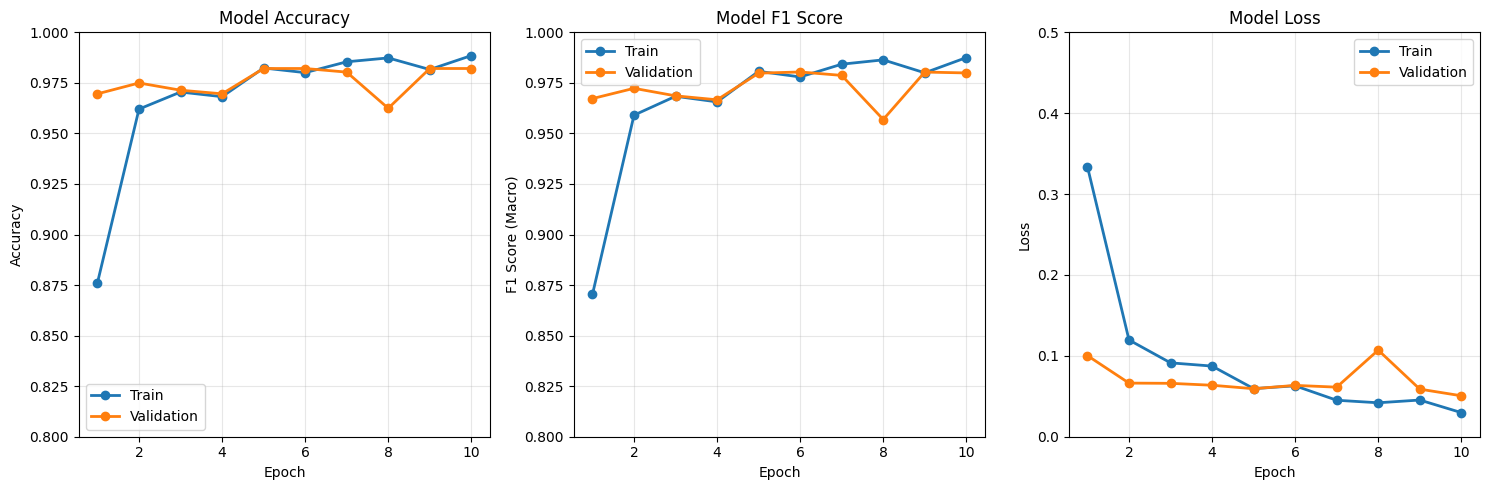

📊 Training Summary:
   Epochs trained: 10
   Best validation F1: 0.9804
   Final train accuracy: 0.9885
   Final validation accuracy: 0.9821


In [27]:
# Plot training curves
if len(train_history['acc']) == 0:
    print('❌ No training history found. Please run the training cell first.')
else:
    epochs_trained = len(train_history['acc'])
    x = list(range(1, epochs_trained + 1))

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(x, train_history['acc'], 'o-', label='Train', linewidth=2, markersize=6)
    plt.plot(x, val_history['acc'], 'o-', label='Validation', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.80, 1.00) # Set y-axis limit for Accuracy

    # F1 Score plot
    plt.subplot(1, 3, 2)
    plt.plot(x, train_history['f1'], 'o-', label='Train', linewidth=2, markersize=6)
    plt.plot(x, val_history['f1'], 'o-', label='Validation', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score (Macro)')
    plt.title('Model F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.80, 1.00) # Set y-axis limit for F1 Score

    # Loss plot
    plt.subplot(1, 3, 3)
    plt.plot(x, train_history['loss'], 'o-', label='Train', linewidth=2, markersize=6)
    plt.plot(x, val_history['loss'], 'o-', label='Validation', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.00, 0.50) # Set y-axis limit for Loss

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=200, bbox_inches='tight')
    plt.show()

    # Print training summary
    print(f'📊 Training Summary:')
    print(f'   Epochs trained: {epochs_trained}')
    print(f'   Best validation F1: {max(val_history["f1"]):.4f}')
    print(f'   Final train accuracy: {train_history["acc"][-1]:.4f}')
    print(f'   Final validation accuracy: {val_history["acc"][-1]:.4f}')

### Evaluation Report

💾 Loading best model...
   ✅ Loaded model from epoch 6
   📊 Best validation F1: 0.9804

🧪 Evaluating on test set...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]


📊 Test Set Results:
   Loss: 0.0589
   Accuracy: 0.9803
   Precision (macro): 0.9801
   Recall (macro): 0.9775
   F1 Score (macro): 0.9788

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       212
   Pneumonia       0.98      0.96      0.97       137
Tuberculosis       1.00      1.00      1.00       210

    accuracy                           0.98       559
   macro avg       0.98      0.98      0.98       559
weighted avg       0.98      0.98      0.98       559



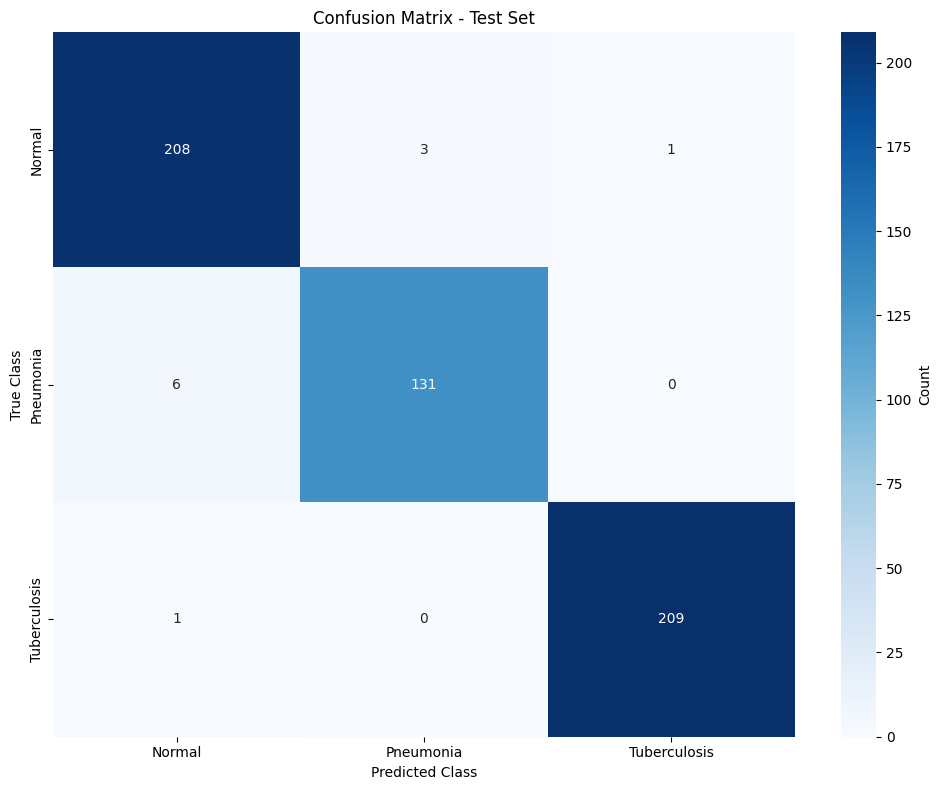


🎯 Per-class Performance:
   Normal:
     Precision: 0.967
     Recall:    0.981
     F1-Score:  0.974
     Support:   212
   Pneumonia:
     Precision: 0.978
     Recall:    0.956
     F1-Score:  0.967
     Support:   137
   Tuberculosis:
     Precision: 0.995
     Recall:    0.995
     F1-Score:  0.995
     Support:   210

📈 AUC Scores:
   Normal: 0.998
   Pneumonia: 0.998
   Tuberculosis: 1.000
   Macro Average: 0.999

💾 All results saved to: outputs/
📊 FINAL MODEL PERFORMANCE SUMMARY
📈  Training Information:
   Epochs trained: 10
   Best validation F1: 0.9804
   Final train accuracy: 0.9885
   Final validation accuracy: 0.9821

🎯 Test Set Performance:
   Accuracy: 0.9803
   Precision (macro): 0.9801
   Recall (macro): 0.9775
   F1-Score (macro): 0.9788

💡 Performance Interpretation:
   Overall Performance: Excellent
   F1-Score: 0.979
   ✅ High accuracy achieved (98.0%)

🚀 Recommendations for Improvement:
   • Collect more training data if possible
   • Try ensemble methods for bet

In [28]:
# Load best model
best_model_path = os.path.join(OUTPUT_DIR, 'best_model.pth')

if os.path.exists(best_model_path):
    print('💾 Loading best model...')
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'   ✅ Loaded model from epoch {checkpoint["epoch"]}')
    print(f'   📊 Best validation F1: {checkpoint["val_f1"]:.4f}')
else:
    print('⚠️  No saved model found. Using current model state.')

# Evaluate on test set only if test_loader is available
if test_loader is not None:
    print('\n🧪 Evaluating on test set...')
    test_loss, test_acc, test_prec, test_rec, test_f1, test_targets, test_preds, test_probs = epoch_eval(
        model, test_loader, criterion, device
    )

    print('\n📊 Test Set Results:')
    print(f'   Loss: {test_loss:.4f}')
    print(f'   Accuracy: {test_acc:.4f}')
    print(f'   Precision (macro): {test_prec:.4f}')
    print(f'   Recall (macro): {test_rec:.4f}')
    print(f'   F1 Score (macro): {test_f1:.4f}')

    # Detailed classification report
    print('\n📋 Detailed Classification Report:')
    report = classification_report(test_targets, test_preds, target_names=class_names, zero_division=0)
    print(report)

    # Save classification report
    with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'w') as f:
        f.write('Test Set Classification Report\n')
        f.write('=' * 40 + '\n')
        f.write(f'Overall Metrics:\n')
        f.write(f'  Accuracy: {test_acc:.4f}\n')
        f.write(f'  Precision (macro): {test_prec:.4f}\n')
        f.write(f'  Recall (macro): {test_rec:.4f}\n')
        f.write(f'  F1 Score (macro): {test_f1:.4f}\n\n')
        f.write('Per-class Report:\n')
        f.write(report)

    # Confusion Matrix
    cm = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix - Test Set')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_test.png'), dpi=200, bbox_inches='tight')
    plt.show()

    # Calculate per-class metrics
    print('\n🎯 Per-class Performance:')
    per_class_prec, per_class_rec, per_class_f1, support = precision_recall_fscore_support(
        test_targets, test_preds, average=None, zero_division=0
    )

    for i, class_name in enumerate(class_names):
        print(f'   {class_name}:')
        print(f'     Precision: {per_class_prec[i]:.3f}')
        print(f'     Recall:    {per_class_rec[i]:.3f}')
        print(f'     F1-Score:  {per_class_f1[i]:.3f}')
        print(f'     Support:   {support[i]}')

    # AUC calculation
    try:
        print('\n📈 AUC Scores:')
        if len(class_names) > 2:
            # Multi-class AUC
            test_targets_binary = label_binarize(test_targets, classes=list(range(len(class_names))))
            if test_targets_binary.shape[1] == 1:
                # Only 2 classes present
                auc_scores = [roc_auc_score(test_targets, test_probs[:, 1])]
            else:
                auc_scores = roc_auc_score(test_targets_binary, test_probs, average=None, multi_class='ovr')
        else:
            # Binary classification
            auc_scores = [roc_auc_score(test_targets, test_probs[:, 1])]

        for i, (class_name, auc) in enumerate(zip(class_names, auc_scores)):
            print(f'   {class_name}: {auc:.3f}')
        print(f'   Macro Average: {np.mean(auc_scores):.3f}')

    except Exception as e:
        print(f'⚠️  AUC calculation failed: {e}')

    print(f'\n💾 All results saved to: {OUTPUT_DIR}/')

else:
    print("\n⚠️ Skipping test set evaluation: test_loader is not available (test directory not found).")


# Generate comprehensive model summary (moved outside the if block)
print('📊 FINAL MODEL PERFORMANCE SUMMARY')
print('=' * 50)

# Load training history if available
try:
    with open(os.path.join(OUTPUT_DIR, 'training_history.json'), 'r') as f:
        history_data = json.load(f)

    print(f'📈  Training Information:')
    print(f'   Epochs trained: {history_data["epochs_trained"]}')
    print(f'   Best validation F1: {history_data["best_val_f1"]:.4f}')

    # Training progression
    final_train_acc = history_data['train']['acc'][-1]
    final_val_acc = history_data['val']['acc'][-1]
    print(f'   Final train accuracy: {final_train_acc:.4f}')
    print(f'   Final validation accuracy: {final_val_acc:.4f}')

except FileNotFoundError:
    print('⚠️  Training history not found.')

# Include test set results in summary if available
if test_loader is not None:
    print(f'\n🎯 Test Set Performance:')
    print(f'   Accuracy: {test_acc:.4f}')
    print(f'   Precision (macro): {test_prec:.4f}')
    print(f'   Recall (macro): {test_rec:.4f}')
    print(f'   F1-Score (macro): {test_f1:.4f}')

    # Performance interpretation based on test F1
    if test_f1 >= 0.9:
        performance_level = "Excellent"
    elif test_f1 >= 0.8:
        performance_level = "Very Good"
    elif test_f1 >= 0.7:
        performance_level = "Good"
    elif test_f1 >= 0.6:
        performance_level = "Fair"
    else:
        performance_level = "Needs Improvement"

    print(f'\n💡 Performance Interpretation:')
    print(f'   Overall Performance: {performance_level}')
    print(f'   F1-Score: {test_f1:.3f}')

    if test_acc > 0.85:
        print(f'   ✅ High accuracy achieved ({test_acc:.1%})')
    else:
        print(f'   ⚠️  Accuracy could be improved ({test_acc:.1%})')

    # Recommendations
    print(f'\n🚀 Recommendations for Improvement:')
    if test_f1 < 0.8:
        print('   • Consider training for more epochs')
        print('   • Try different learning rates or optimizers')
        print('   • Experiment with data augmentation techniques')
        print('   • Consider using a larger model (ResNet34/50)')

    if abs(final_train_acc - test_acc) > 0.1:
        print('   • Model may be overfitting - consider more regularization')
        print('   • Add more dropout or reduce model complexity')

    print('   • Collect more training data if possible')
    print('   • Try ensemble methods for better performance')

else:
    print("\n⚠️ Test set evaluation skipped. Cannot provide test performance metrics or interpretation.")
    performance_level = "Unknown (Test set not available)"
    test_acc = test_prec = test_rec = test_f1 = float('nan') # Assign NaN if test results not available


print(f'\n🎉 Analysis Complete!')
print(f'   All results saved to: {os.path.abspath(OUTPUT_DIR)}/')

# Save final summary
summary_text = f"""
Chest X-ray Classification Model Summary
=======================================

Model Architecture: ResNet18 (pretrained)
Dataset: {len(class_names) if 'class_names' in globals() else 'Unknown'} classes ({', '.join(class_names) if 'class_names' in globals() else 'Unknown'})
Total Images: {len(train_dataset) + len(val_dataset) + (len(test_dataset) if test_dataset else 0) if 'train_dataset' in globals() and 'val_dataset' in globals() else 'Unknown'}

Performance Metrics:
- Test Accuracy: {test_acc:.4f}
- Test F1-Score: {test_f1:.4f}
- Test Precision: {test_prec:.4f}
- Test Recall: {test_rec:.4f}

Training Details:
- Epochs: {history_data.get('epochs_trained', 'Unknown')}
- Best Val F1: {history_data.get('best_val_f1', 'Unknown')}
- Performance Level: {performance_level}

Generated: {os.path.basename(__file__) if '__file__' in globals() else 'Jupyter Notebook'}
"""

with open(os.path.join(OUTPUT_DIR, 'model_summary.txt'), 'w') as f:
    f.write(summary_text)

print('📄 Model summary saved to: outputs/model_summary.txt')

### GradCAM

🔎 Setting up GradCAM visualization...
   ✅ GradCAM instance created.
🎨 Generating GradCAM visualizations...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


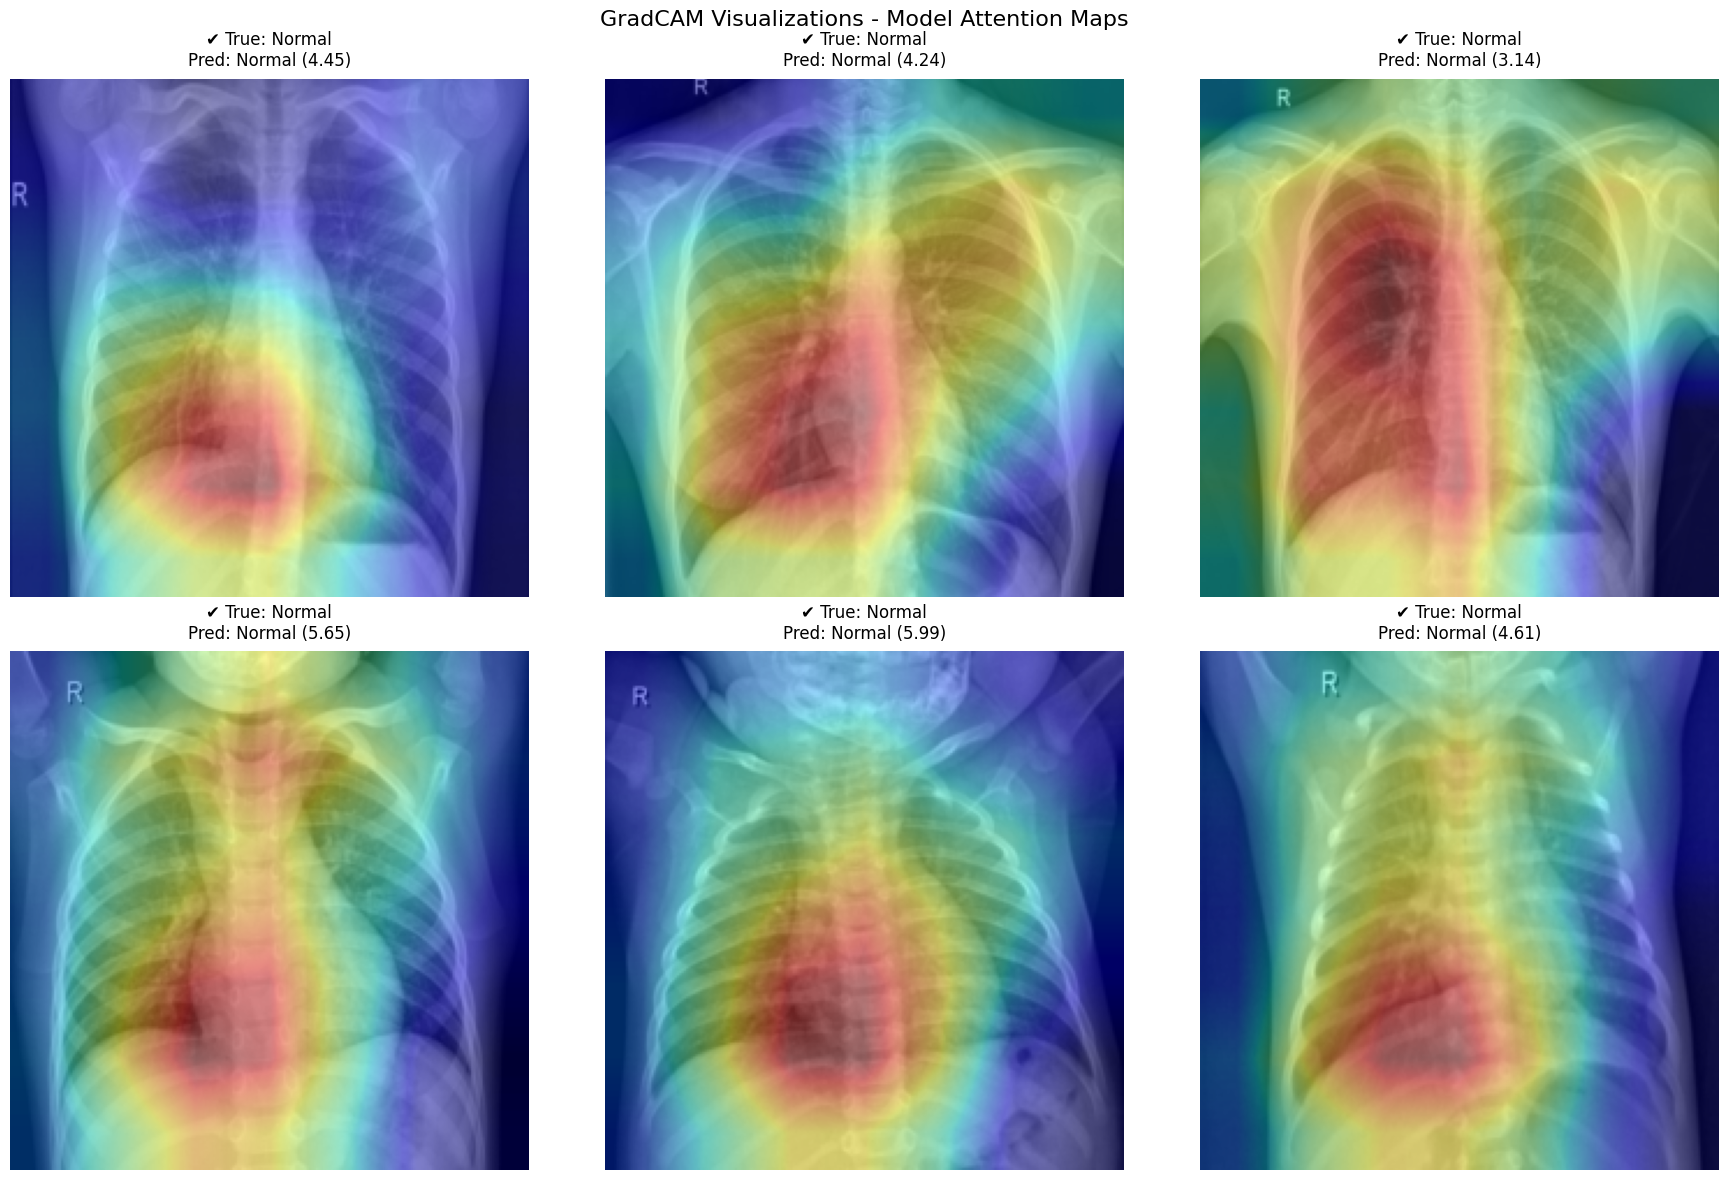

✅ GradCAM visualizations complete!
   Generated 6 visualizations
   Saved to: outputs/gradcam_visualizations.png
📊 FINAL MODEL PERFORMANCE SUMMARY
📈  Training Information:
   Epochs trained: 10
   Best validation F1: 0.9804
   Final train accuracy: 0.9885
   Final validation accuracy: 0.9821

🎯 Test Set Performance:
   Accuracy: 0.9803
   Precision (macro): 0.9801
   Recall (macro): 0.9775
   F1-Score (macro): 0.9788

💡 Performance Interpretation:
   Overall Performance: Excellent
   F1-Score: 0.979
   ✅ High accuracy achieved (98.0%)

🚀 Recommendations for Improvement:
   • Collect more training data if possible
   • Try ensemble methods for better performance

📂 Generated Files:
   ✅ best_model.pth (134223.4 KB)
   ✅ training_history.json (2.9 KB)
   ✅ classification_report.txt (0.6 KB)
   ✅ training_curves.png (154.4 KB)
   ✅ confusion_matrix_test.png (74.7 KB)
   ✅ gradcam_visualizations.png (1953.3 KB)

🏗️  Model Architecture:
   Architecture: ResNet18 (pretrained)
   Input size: 

In [29]:
# GradCAM implementation for model interpretability
try:
    import cv2
except ImportError:
    print("⚠️  OpenCV not found. Installing...")
    os.system("pip install opencv-python")
    import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradient)

    def save_gradient(self, module, grad_in, grad_out):
        if grad_out[0] is not None:
            self.gradients = grad_out[0].detach()

    def save_activation(self, module, inp, out):
        self.activations = out.detach()

    def generate_cam(self, input_tensor, class_idx=None):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Backward pass
        score = output[0, class_idx]
        score.backward(retain_graph=True)

        # Generate CAM
        gradients = self.gradients[0]  # Remove batch dimension
        activations = self.activations[0]  # Remove batch dimension

        # Compute weights (global average pooling of gradients)
        weights = torch.mean(gradients.view(gradients.size(0), -1), dim=1)

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, weight in enumerate(weights):
            cam += weight * activations[i, :, :]

        # Apply ReLU and normalize
        cam = torch.relu(cam)
        if cam.max() > 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam.cpu().numpy(), class_idx, output[0, class_idx].item()

    def __del__(self):
        # Clean up hooks
        if hasattr(self, 'forward_hook'):
            self.forward_hook.remove()
        if hasattr(self, 'backward_hook'):
            self.backward_hook.remove()

def denormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor for visualization."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Initialize GradCAM
print('🔎 Setting up GradCAM visualization...')
# Check if model and layer4 exist before creating GradCAM instance
if 'model' in globals() and hasattr(model, 'layer4') and len(model.layer4) > 0:
    try:
        gradcam = GradCAM(model, target_layer=model.layer4[-1])  # Last ResNet block
        print('   ✅ GradCAM instance created.')

        # Create visualization
        print('🎨 Generating GradCAM visualizations...')
        model.eval()
        visualization_count = 0
        max_visualizations = 6

        plt.figure(figsize=(18, 12))

        # Check if test_loader is available before iterating
        if test_loader is not None:
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(test_loader):
                    if visualization_count >= max_visualizations:
                        break

                    for i in range(min(3, images.size(0))):
                        if visualization_count >= max_visualizations:
                            break

                        # Get single image
                        img_tensor = images[i].unsqueeze(0).to(device)
                        true_label = labels[i].item()

                        # Generate GradCAM
                        with torch.enable_grad(): # Enable grad for CAM calculation
                            cam, pred_class, confidence = gradcam.generate_cam(img_tensor)

                        # Prepare image for display
                        img_display = denormalize_tensor(images[i])
                        img_display = torch.clamp(img_display, 0, 1)
                        img_display = img_display.permute(1, 2, 0).cpu().numpy()

                        # Resize CAM to match image size
                        cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

                        # Create subplot
                        plt.subplot(2, 3, visualization_count + 1)

                        # Display original image
                        plt.imshow(img_display)

                        # Overlay heatmap
                        plt.imshow(cam_resized, cmap='jet', alpha=0.4, interpolation='bilinear')

                        # Labels and title
                        true_class = class_names[true_label]
                        pred_class_name = class_names[pred_class]
                        correct = "✔" if true_label == pred_class else "❌"

                        plt.title(f'{correct} True: {true_class}\nPred: {pred_class_name} ({confidence:.2f})',
                                 fontsize=12, pad=10)
                        plt.axis('off')

                        visualization_count += 1

            plt.suptitle('GradCAM Visualizations - Model Attention Maps', fontsize=16, y=0.98)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, 'gradcam_visualizations.png'), dpi=200, bbox_inches='tight')
            plt.show()

            print(f'✅ GradCAM visualizations complete!')
            print(f'   Generated {visualization_count} visualizations')
            print(f'   Saved to: {OUTPUT_DIR}/gradcam_visualizations.png')

        else:
            print("\n⚠️ Skipping GradCAM visualizations: test_loader is not available (test directory not found).")
            plt.close() # Close the figure if no visualizations were generated

    except Exception as e:
        print(f"❌ Error during GradCAM visualization setup or generation: {e}")
        plt.close() # Ensure figure is closed on error
else:
    print("\n❌ Cannot set up GradCAM: Model or target layer ('layer4') not found. Please ensure the model was built successfully.")
    plt.figure(figsize=(18, 12)) # Create a dummy figure to avoid subsequent errors
    plt.close()


# Generate comprehensive model summary (moved outside the if block)
print('📊 FINAL MODEL PERFORMANCE SUMMARY')
print('=' * 50)

# Load training history if available
try:
    with open(os.path.join(OUTPUT_DIR, 'training_history.json'), 'r') as f:
        history_data = json.load(f)

    print(f'📈  Training Information:')
    print(f'   Epochs trained: {history_data["epochs_trained"]}')
    print(f'   Best validation F1: {history_data["best_val_f1"]:.4f}')

    # Training progression
    final_train_acc = history_data['train']['acc'][-1]
    final_val_acc = history_data['val']['acc'][-1]
    print(f'   Final train accuracy: {final_train_acc:.4f}')
    print(f'   Final validation accuracy: {final_val_acc:.4f}')

except FileNotFoundError:
    print('⚠️  Training history not found.')

# Include test set results in summary if available
# Need to ensure test_acc, test_prec, test_rec, test_f1 are available or handle if skipped
# These variables are defined within the 'if test_loader is not None:' block in the Evaluation Report cell.
# If evaluation was skipped, they might not be defined or might be NaN.
# Let's try to load them from the summary file if available, or report as unknown.
test_acc = test_prec = test_rec = test_f1 = float('nan') # Initialize as NaN

if os.path.exists(os.path.join(OUTPUT_DIR, 'classification_report.txt')):
    try:
        with open(os.path.join(OUTPUT_DIR, 'classification_report.txt'), 'r') as f:
            report_content = f.read()
            # Simple parsing to get overall metrics
            if 'Accuracy:' in report_content:
                test_acc = float(report_content.split('Accuracy:')[1].split('\n')[0].strip())
            if 'Precision (macro):' in report_content:
                test_prec = float(report_content.split('Precision (macro):')[1].split('\n')[0].strip())
            if 'Recall (macro):' in report_content:
                test_rec = float(report_content.split('Recall (macro):')[1].split('\n')[0].strip())
            if 'F1 Score (macro):' in report_content:
                test_f1 = float(report_content.split('F1 Score (macro):')[1].split('\n')[0].strip())
    except Exception as e:
        print(f"⚠️ Error reading test set metrics from report file: {e}")


print(f'\n🎯 Test Set Performance:')
if not np.isnan(test_f1):
    print(f'   Accuracy: {test_acc:.4f}')
    print(f'   Precision (macro): {test_prec:.4f}')
    print(f'   Recall (macro): {test_rec:.4f}')
    print(f'   F1-Score (macro): {test_f1:.4f}')
else:
     print('   Test set evaluation was skipped or metrics not available.')


# Performance interpretation based on test F1
if not np.isnan(test_f1):
    if test_f1 >= 0.9:
        performance_level = "Excellent"
    elif test_f1 >= 0.8:
        performance_level = "Very Good"
    elif test_f1 >= 0.7:
        performance_level = "Good"
    elif test_f1 >= 0.6:
        performance_level = "Fair"
    else:
        performance_level = "Needs Improvement"

    print(f'\n💡 Performance Interpretation:')
    print(f'   Overall Performance: {performance_level}')
    print(f'   F1-Score: {test_f1:.3f}')

    if test_acc > 0.85:
        print(f'   ✅ High accuracy achieved ({test_acc:.1%})')
    else:
        print(f'   ⚠️  Accuracy could be improved ({test_acc:.1%})')

    # Recommendations
    print(f'\n🚀 Recommendations for Improvement:')
    if test_f1 < 0.8:
        print('   • Consider training for more epochs')
        print('   • Try different learning rates or optimizers')
        print('   • Experiment with data augmentation techniques')
        print('   • Consider using a larger model (ResNet34/50)')

    if 'final_train_acc' in locals() and not np.isnan(test_acc) and abs(final_train_acc - test_acc) > 0.1:
        print('   • Model may be overfitting - consider more regularization')
        print('   • Add more dropout or reduce model complexity')

    print('   • Collect more training data if possible')
    print('   • Try ensemble methods for better performance')

else:
    print("\n⚠️ Performance interpretation skipped as test set evaluation was skipped.")
    performance_level = "Unknown (Test set not available)"


print(f'\n📂 Generated Files:')
output_files = [
    'best_model.pth',
    'training_history.json',
    'classification_report.txt',
    'training_curves.png',
    'confusion_matrix_test.png',
    'gradcam_visualizations.png'
]

for filename in output_files:
    filepath = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath) / 1024  # KB
        print(f'   ✅ {filename} ({file_size:.1f} KB)')
    else:
        print(f'   ❌ {filename} (missing)')

# Model architecture summary
print(f'\n🏗️  Model Architecture:')
# Need to ensure model, IMG_SIZE, NUM_CLASSES, class_names are defined
if 'model' in globals() and 'IMG_SIZE' in globals() and 'NUM_CLASSES' in globals() and 'class_names' in globals():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'   Architecture: ResNet18 (pretrained)')
    print(f'   Input size: {IMG_SIZE}×{IMG_SIZE}')
    print(f'   Number of classes: {NUM_CLASSES}')
    print(f'   Total parameters: {total_params:,}')
    print(f'   Trainable parameters: {trainable_params:,}')
    print(f'   Classes: {", ".join(class_names)}')
else:
    print('   Model architecture details not available (model or related variables not defined).')


# Dataset summary
print(f'\n📊 Dataset Summary:')
# Need to ensure train_dataset, val_dataset, test_dataset are defined
if 'train_dataset' in globals() and 'val_dataset' in globals():
    total_images = len(train_dataset) + len(val_dataset) + (len(test_dataset) if 'test_dataset' in globals() and test_dataset is not None else 0)
    print(f'   Total images: {total_images}')
    print(f'   Train: {len(train_dataset)} images')
    print(f'   Validation: {len(val_dataset)} images')
    if 'test_dataset' in globals() and test_dataset is not None:
         print(f'   Test: {len(test_dataset)} images')
    else:
         print('   Test: 0 images (dataset not available)')
else:
    print('   Dataset summary not available (datasets not defined).')


print(f'\n🎉 Analysis Complete!')
print(f'   All results saved to: {os.path.abspath(OUTPUT_DIR)}/')

# Save final summary
# Need to ensure all variables used in summary_text are defined or handled
summary_text = f"""
Chest X-ray Classification Model Summary
=======================================

Model Architecture: ResNet18 (pretrained)
Dataset: {len(class_names) if 'class_names' in globals() else 'Unknown'} classes ({', '.join(class_names) if 'class_names' in globals() and class_names else 'Unknown'})
Total Images: {len(train_dataset) + len(val_dataset) + (len(test_dataset) if 'test_dataset' in globals() and test_dataset is not None else 0) if 'train_dataset' in globals() and 'val_dataset' in globals() else 'Unknown'}

Performance Metrics:
- Test Accuracy: {'N/A' if np.isnan(test_acc) else f'{test_acc:.4f}'}
- Test F1-Score: {'N/A' if np.isnan(test_f1) else f'{test_f1:.4f}'}
- Test Precision: {'N/A' if np.isnan(test_prec) else f'{test_prec:.4f}'}
- Test Recall: {'N/A' if np.isnan(test_rec) else f'{test_rec:.4f}'}

Training Details:
- Epochs: {history_data.get('epochs_trained', 'Unknown') if 'history_data' in locals() else 'Unknown'}
- Best Val F1: {history_data.get('best_val_f1', 'Unknown') if 'history_data' in locals() else 'Unknown'}
- Performance Level: {performance_level if 'performance_level' in locals() else 'Unknown'}

Generated: {os.path.basename(__file__) if '__file__' in globals() else 'Jupyter Notebook'}
"""

with open(os.path.join(OUTPUT_DIR, 'model_summary.txt'), 'w') as f:
    f.write(summary_text)

print('📄 Model summary saved to: outputs/model_summary.txt')